В решении задачи классификации новостей по категориям, я провел системный анализ, начиная с Exploratory Data Analysis (EDA) и Feature Engineering. Для улучшения обработки текста и повышения точности классификации был использован ряд методов. Вначале был проведен анализ словосочетаний с построением Word Cloud для каждой темы, что помогло расширить список стоп-слов.

Далее, для предобработки текста, я устранил пунктуацию, привел все слова к нижнему регистру и применил лемматизацию. Этот этап был важен для нормализации текста и уменьшения размерности признакового пространства.

В процессе экспериментов с различными методами векторизации текста и обучения моделей, я рассмотрел три основных подхода. Первый включал в себя векторизацию с использованием tf-idf и обучение моделей SVM и Naive Bayes. Однако, несмотря на хорошие результаты SVM, обнаружилось, что количество признаков превышает 2 миллиона, что может стать проблемой для эффективного обучения и использования модели в практических задачах.

Далее был использован метод word2vec для векторизации текста, с последующим обучением моделей SVM, KNN и XGBoost. В этом случае, хотя уменьшилось количество признаков до 300, результаты классификации оказались несколько менее точными.

В конечном итоге, был выбран третий подход, включающий векторизацию через word2vec и tf-idf. Этот метод позволил создать вектора признаков, усредненные с учетом весов tf-idf для каждого слова. Модели SVM, KNN и XGBoost были обучены на таких векторах, и результаты оказались сопоставимыми с предыдущими экспериментами.

Наконец, для построения классификатора, выбран word2vec+tf-idf, усредненные с весами tf-idf, и модель K-Nearest Neighbors (KNN). Этот выбор обоснован сбалансированным сочетанием точности и эффективности модели. Обученный классификатор теперь способен определять целевой класс для новых текстовых данных, предоставляя решение задачи классификации новостей по категориям с высокой точностью.

# Содержание
1. [EDA](#eda)
2. [Feature Engineering](#feature_engineering)
3. [tf-idf](#tf_idf)
   - [SVM](#tf_svm) 
   - [MultinomialNB](#tf_nb)
4. [word2vec](#wv)
   - [SVM](#wv_svm) 
   - [KNN](#wv_knn)
   - [XGBoost](#wv_xgb) 
5. [word2vec & tf-idf](#wvidf)
   - [SVM](#wvidf_svm) 
   - [KNN](#wvidf_knn)
   - [XGBoost](#wvidf_xgb) 
6. [NewsClassifier](#news_clf)

In [121]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import defaultdict
from pymystem3 import Mystem  # Подгружаем Mystem из библиотеки pymystem3
from functools import lru_cache
from tqdm import tqdm  # Импортируем tqdm для отслеживания прогресса

# Загружаем стоп-слова для библиотеки nltk
nltk.download('stopwords')

# Инициализация Mystem для лемматизации текста
mystem = Mystem()

# Декоратор lru_cache используется для кэширования результатов вызова функции
from functools import lru_cache
# Инициализация tqdm для отслеживания прогресса выполнения операций
tqdm.pandas()

[nltk_data] Downloading package stopwords to /Users/bulat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA <a id='eda'></a>

Чтение данных из CSV файла в DataFrame


In [122]:
df = pd.read_csv('test.csv')

Вывод первых нескольких строк DataFrame для проверки данных


In [3]:
df.head()

,title,text,topic
0,Британцы отмечают двухлетие смерти Дианы,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
1,Еще одно землетрясение в Турции: один человек ...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
2,Российские национал-большевики убирают террито...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
3,Киргизия ведет бои на границах с Таджикистаном...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
4,Литва засудила участников переворота 91 года,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир


Вывод общей информации о DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432158 entries, 0 to 432157
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   432158 non-null  object
 1   text    432158 non-null  object
 2   topic   432158 non-null  object
dtypes: object(3)
memory usage: 9.9+ MB


Подсчет пропущенных значений в каждом столбце


In [5]:
df.isna().sum()

title    0
text     0
topic    0
dtype: int64

Поиск и вывод всех дублирующихся строк в DataFrame


In [6]:
df[df.duplicated(keep=False)]

,title,text,topic
17709,Европейский союз составит досье на антиглобали...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
18164,Европейский союз составит досье на антиглобали...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Мир
33723,В финале St Petersburg Open Южный проиграл Гро...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Спорт
33733,В финале St Petersburg Open Южный проиграл Гро...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Спорт
61916,В прокат выходит призер последнего Венецианско...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Культура
61963,В прокат выходит призер последнего Венецианско...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Культура
63561,"Российское издание диска Eminem ""Encore"" появи...","<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Культура
63769,"Российское издание диска Eminem ""Encore"" появи...","<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Культура
64131,Французский режиссер похитил президента Франци...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Культура
64151,Французский режиссер похитил президента Франци...,"<?xml version=""1.0"" encoding=""utf-8""?>\n<conve...",Культура


Удаление дубликатов в DataFrame

In [23]:
df.drop_duplicates(inplace=True)

# Вывод размера DataFrame после удаления дубликатов
df.shape

(432147, 4)

Посмотрим на столбец 'title' из DataFrame

In [8]:
df['title']

0                  Британцы отмечают двухлетие смерти Дианы
1         Еще одно землетрясение в Турции: один человек ...
2         Российские национал-большевики убирают террито...
3         Киргизия ведет бои на границах с Таджикистаном...
4              Литва засудила участников переворота 91 года
                                ...                        
432153    Россия предложила Китаю участвовать в судьбе р...
432154               Моуринью сравнил футболистов с мебелью
432155          Путин предостерег от запретов рэп-концертов
432156    «Желтые жилеты» прорвали кордон полиции под «М...
432157    Падение горнолыжника на полной скорости попало...
Name: title, Length: 432147, dtype: object

In [9]:
# Вывод описательной статистики для столбца 'title'
df['title'].describe()

count                                432147
unique                               430379
top       ЦБ отозвал лицензии у двух банков
freq                                     16
Name: title, dtype: object

Посмотрим на столбец 'text' из DataFrame

In [10]:
df['text']

0         <?xml version="1.0" encoding="utf-8"?>\n<conve...
1         <?xml version="1.0" encoding="utf-8"?>\n<conve...
2         <?xml version="1.0" encoding="utf-8"?>\n<conve...
3         <?xml version="1.0" encoding="utf-8"?>\n<conve...
4         <?xml version="1.0" encoding="utf-8"?>\n<conve...
                                ...                        
432153    <?xml version="1.0" encoding="utf-8"?>\n<conve...
432154    <?xml version="1.0" encoding="utf-8"?>\n<conve...
432155    <?xml version="1.0" encoding="utf-8"?>\n<conve...
432156    <?xml version="1.0" encoding="utf-8"?>\n<conve...
432157    <?xml version="1.0" encoding="utf-8"?>\n<conve...
Name: text, Length: 432147, dtype: object

In [123]:
# Удалим xml формат со столбца 'text'
df['text'] = df['text'].apply(lambda text: text[59:-22] if isinstance(text, str) else x)

In [13]:
df['text']

0         Британцы отмечают сегодня скорбную дату - втор...
1         подземный толчок силой 5,2 балла На северо-зап...
2         15 представителей национал-большевистской парт...
3         На юге Киргизии, а именно в Баткенском и Чон-А...
4         Россия крайне негативно оценивает судебный про...
                                ...                        
432153    Россия призвала Китай принять участие в перего...
432154    Главный тренер «Манчестер Юнайтед» Жозе Моурин...
432155    Президент России Владимир Путин, выступая на з...
432156    Протесты движения «желтых жилетов» в Париже сн...
432157    Швейцарский горнолыжник Марк Гизин неудачно пр...
Name: text, Length: 432147, dtype: object

In [14]:
# Вывод описательной статистики для столбца 'text'
df['text'].describe()

count            432147
unique           431636
top       РИА "Новости"
freq                127
Name: text, dtype: object

Посомтрим на целевую переменную 'topic'

In [15]:
# Вывод относительных частот значений в столбце 'topic'
df['topic'].value_counts(normalize=True)

topic
Мир                0.316142
Экономика          0.184028
Спорт              0.149049
Культура           0.124474
Наука и техника    0.122956
Интернет и СМИ     0.103351
Name: proportion, dtype: float64

In [16]:
# Извлечение уникальных значений из столбца 'topic'
target_category = df['topic'].unique()
target_category

array(['Мир', 'Экономика', 'Интернет и СМИ', 'Спорт', 'Культура',
       'Наука и техника'], dtype=object)

In [17]:
# Создание нового столбца 'topic_id' с уникальными целочисленными идентификаторами для каждого значения в столбце 'topic'
df['topic_id'] = df['topic'].factorize()[0]
df.head()

,title,text,topic,topic_id
0,Британцы отмечают двухлетие смерти Дианы,Британцы отмечают сегодня скорбную дату - втор...,Мир,0
1,Еще одно землетрясение в Турции: один человек ...,"подземный толчок силой 5,2 балла На северо-зап...",Мир,0
2,Российские национал-большевики убирают террито...,15 представителей национал-большевистской парт...,Мир,0
3,Киргизия ведет бои на границах с Таджикистаном...,"На юге Киргизии, а именно в Баткенском и Чон-А...",Мир,0
4,Литва засудила участников переворота 91 года,Россия крайне негативно оценивает судебный про...,Мир,0


In [18]:
# Создание DataFrame 'category' с уникальными значениями из столбцов 'topic' и 'topic_id', отсортированными по 'topic_id'
category = df[['topic', 'topic_id']].drop_duplicates().sort_values('topic_id')
category

,topic,topic_id
0,Мир,0
227,Экономика,1
457,Интернет и СМИ,2
2081,Спорт,3
5061,Культура,4
52707,Наука и техника,5


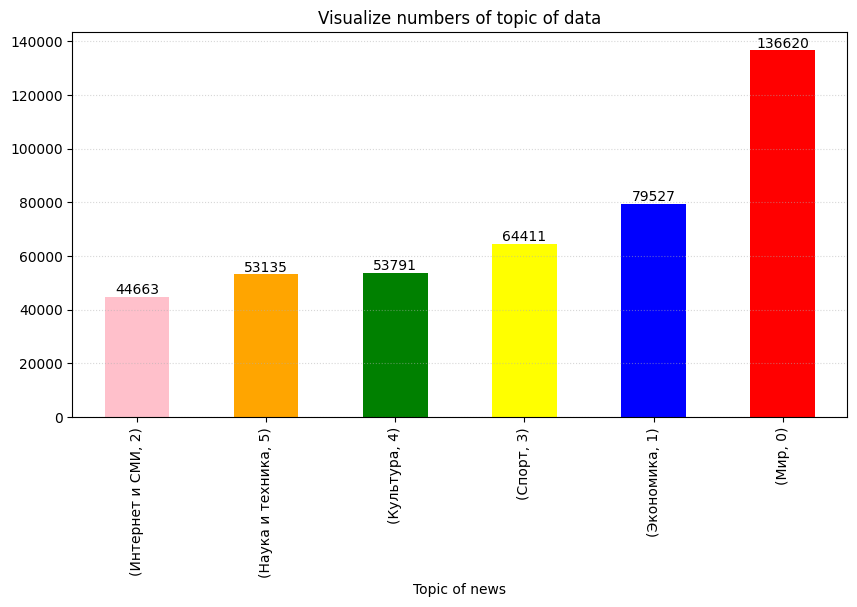

In [24]:
# Визуальное распределение целевой переменной topic
plt.figure(figsize=(10, 5))

# Группировка данных по столбцу 'topic' и подсчет частоты каждого 'topic_id'
ax = df.groupby('topic')['topic_id'].value_counts().sort_values().plot(kind="bar", 
                                                                       color=["pink", "orange", "green", "yellow", "blue", 'red'])

# Добавление меток с частотами над каждым столбцом
for i in ax.containers:
    ax.bar_label(i, fmt='%d', label_type='edge', fontsize=10, color='black')

# Настройка подписей осей и заголовка
plt.xlabel("Topic of news")
plt.title("Visualize numbers of topic of data")
plt.grid(True, ls=':', alpha=0.5, axis='y')


Посмотрим на облака слов для каждой темы с помощью библиотеки WordCloud

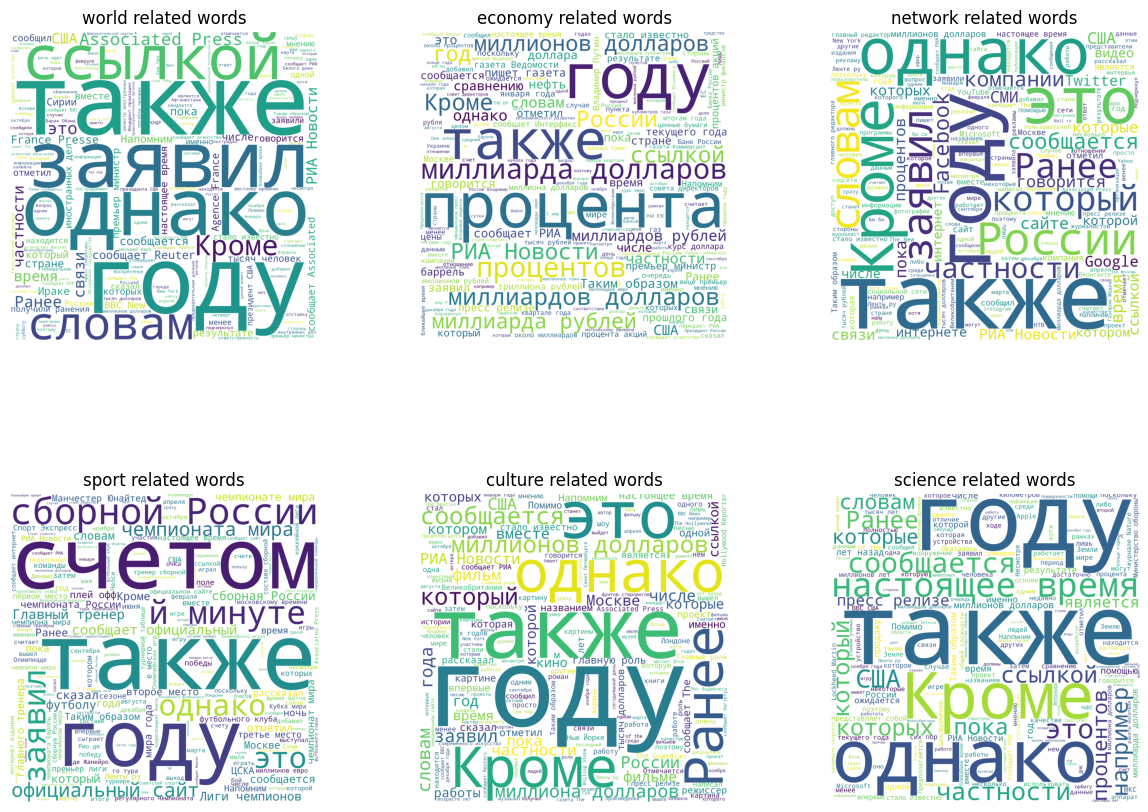

In [25]:
# Установка стоп-слов для русского языка
stop = set(stopwords.words('russian'))

# Словарь тем
topics = {
    0: 'world',
    1: 'economy',
    2: 'network',
    3: 'sport',
    4: 'culture',
    5: 'science'
}

def get_topic_words(topic_id):
    """Получение слов, связанных с определенной темой."""
    return df[df['topic_id'] == topic_id]['text']

def wordcloud_draw(dataset, ax, color='white'):
    """Функция для отрисовки облака слов."""
    words = ' '.join(dataset)
    cleaned_word = ' '.join([word for word in words.split() if word not in ['news', 'text']])
    wordcloud = WordCloud(stopwords=stop, background_color=color, width=2500, height=2500).generate(cleaned_word)
    ax.imshow(wordcloud)
    ax.axis("off")

# Создание сетки subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# Генерация word cloud для каждой темы
for i, (topic_id, topic_name) in enumerate(topics.items()):
    row = i // 3
    col = i % 3
    axs[row, col].set_title(f"{topic_name} related words")
    wordcloud_draw(get_topic_words(topic_id), axs[row, col], 'white')

# Feature Engineering <a id='feature_engineering'></a>

In [124]:
class Pipeline(object):
    '''Класс Pipeline представляет собой последовательность трансформаций данных.'''
    def __init__(self, *args):
        # Инициализируется списком функций-трансформаторов, которые будут применены последовательно.
        self.transformations = args
        
    def __call__(self, x):
        # Метод __call__ позволяет экземпляру класса быть вызванным как функция.
        # Принимает входные данные x и применяет к ним все трансформации из списка.
        res = x
        for f in self.transformations:
            res = f(res)
        # Возвращает результат после применения всех трансформаций.
        return res


In [125]:
from nltk.corpus import stopwords
from stop_words import get_stop_words

# Получение стоп-слов для английского и русского языков
en_stop_words = set(get_stop_words('en')) | set(stopwords.words('english'))
ru_stop_words = set(get_stop_words('ru')) | set(stopwords.words('russian'))

# Общий набор стоп-слов
COMMON_STOP_WORDS = {'также', 'новость', 'новости', 'однако',
                    'это', 'кроме', 'который', 'которая', 'которые',
                    'которое', 'котором', 'которых', 'кроме',
                    'году', 'год', 'годом', 'года', 'лента',
                    'риа', 'тасс', 'редакция', 'газета', 'интерфакс',
                    'village', 'reuters', 'уточняться', 'частности', 
                    'сообщать', 'сообщается', 'сообщает', 'заявил',
                    'заявить', 'оффициальный', 'заявлять',  'оффициально',
                    'таким', 'образ', 'образом', 'данный', 'ранее', 'уточняться'}

# Общий набор стоп-слов для всех языков
STOP_WORDS = en_stop_words | ru_stop_words | COMMON_STOP_WORDS

def get_lower(text):
    """Преобразование текста в нижний регистр."""
    return str(text).lower()

def remove_punctuation(text):
    """Удаление неалфавитных символов с сохранением дефисов и апострофов."""
    return ''.join([c if c.isalpha() or c in ['-', "'"] else ' ' for c in text])

@lru_cache(maxsize=None)
def get_word_normal_form(word):
    """Получение нормальной формы слова с использованием Mystem."""
    return ''.join(mystem.lemmatize(word)).strip().replace('ё', 'е').strip('-')
    
def lemmatize_words(text):
    """Лемматизация слов в заданном тексте и фильтрация стоп-слов."""
    return ' '.join([get_word_normal_form(word) for word in text.split() if len(get_word_normal_form(word)) > 2 and get_word_normal_form(word) not in STOP_WORDS])


In [126]:
# Пайплайн для обработки текта
TEXT_PIPELINE = Pipeline(get_lower, remove_punctuation, lemmatize_words)

In [127]:
%%time
# Применение пайплайна обработки текста к столбцу 'text'
df['text'] = df['text'].progress_apply(TEXT_PIPELINE)

100%|█████████████████████████████████| 432158/432158 [01:31<00:00, 4704.20it/s]


CPU times: user 53.9 s, sys: 5.28 s, total: 59.2 s
Wall time: 1min 32s


In [129]:
%%time
# Применение пайплайна обработки текста к столбцу 'title'
df['title'] = df['title'].progress_apply(TEXT_PIPELINE)

100%|███████████████████████████████| 432158/432158 [00:02<00:00, 164559.71it/s]

CPU times: user 2.38 s, sys: 55.2 ms, total: 2.44 s
Wall time: 2.63 s


In [130]:
df.head()

,title,text,topic
0,британец отмечать двухлетие смерть диана,британец отмечать скорбный дата вторуюгодовщин...,Мир
1,землетрясение турция погибать ранить,подземный толчок сила балл северо-запад турция...,Мир
2,российский национал-большевик убирать территор...,представитель национал-большевистский партия р...,Мир
3,киргизия вести бой граница таджикистан узбекистан,киргизия баткенский чон-алайскомрайон ошский о...,Мир
4,литва засуживать участник переворот,россия крайне негативно оценивать судебный про...,Мир


In [35]:
# Создаем словарь, используя defaultdict, чтобы избежать ошибок, если ключ отсутствует
vocabulary = defaultdict(int)

# Итерируемся по каждой строке (новости) в DataFrame df
for news in tqdm(df.itertuples()):
    # Разбиваем текст новости на слова и итерируемся по каждому слову
    for word in news.text.split():
        # Увеличиваем счетчик слова в словаре
        vocabulary[word] += 1

# Выводим количество уникальных слов в датасете
print('Unique words in dataset:', len(vocabulary))

432147it [00:09, 46223.06it/s]

Unique words in dataset: 480607


In [40]:
# Посмотрим на количество слов, встречающихся более 3 раз.

n_min_occurrence = 3  # Минимальное количество появлений слова, чтобы оно было учтено
# Фильтруем словарь по минимальному количеству появлений
filtered_vocab = list(filter(lambda x: x[1] >= n_min_occurrence, vocabulary.items()))

# Выводим количество слов, которые встречаются больше или равно n_min_occurrence раз
print('Количество слов, встреченных более %d раз: %d' %
      (n_min_occurrence, len(filtered_vocab)))

Количество слов, встреченных более 3 раз: 195934


In [41]:
# Top k самые частые слова вместе с их частотами.

top_k = 20  # Количество слов, которые будут выведены в топе
print('Топ %d наиболее частых слов:' % top_k)

# Сортировка словаря по убыванию частоты и выбор top_k
sorted_vocab = sorted(vocabulary.items(), key=lambda x: -x[1])[:top_k]

# Вывод топовых слов и их частоты
for i, (word, freq) in enumerate(sorted_vocab):
    print(i+1, word, freq)


Топ 20 наиболее частых слов:
1 россия 245586
2 свой 238857
3 компания 215663
4 процент 195508
5 становиться 189413
6 доллар 178645
7 страна 176483
8 сша 176014
9 российский 165143
10 получать 141177
11 слово 138331
12 миллион 138271
13 отмечать 126170
14 президент 123558
15 новый 121065
16 тысяча 119012
17 миллиард 109650
18 американский 108467
19 составлять 105579
20 являться 103902


In [42]:
df.head()

,title,text,topic,topic_id
0,британец отмечать двухлетие смерть диана,британец отмечать скорбный дата вторуюгодовщин...,Мир,0
1,землетрясение турция погибать ранить,подземный толчок сила балл северо-запад турция...,Мир,0
2,российский национал-большевик убирать территор...,представитель национал-большевистский партия р...,Мир,0
3,киргизия вести бой граница таджикистан узбекистан,киргизия баткенский чон-алайскомрайон ошский о...,Мир,0
4,литва засуживать участник переворот,россия крайне негативно оценивать судебный про...,Мир,0


# tf-idf <a id='tf_idf'></a>

In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [43]:
# Используем LabelEncoder от scikit-learn для кодирования столбца "topic".

le = LabelEncoder()
df['topic_id'] = le.fit_transform(df['topic'])

In [44]:
# Создание целевой пременной, объедняя столбцы 'title' и 'text'
X = pd.DataFrame(df['title'] + ' ' + df['text'], columns=['text'])

# Присвоение столбца 'topic_id' целевой переменной y
y = df['topic_id']

In [47]:
X.head()

,text
0,британец отмечать двухлетие смерть диана брита...
1,землетрясение турция погибать ранить подземный...
2,российский национал-большевик убирать территор...
3,киргизия вести бой граница таджикистан узбекис...
4,литва засуживать участник переворот россия кра...


In [49]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [50]:
%%time
# Создание и обучение TF-IDF векторизатора

# min_df=3 указывает, что слово должно встречаться в минимуме 3 документах для учета
# ngram_range=(1,2) указывает на униграммы и биграммы
# lowercase=False гарантирует чувствительность к регистру

tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,2), lowercase=False).fit(X['text'])

# Вывод размера словаря после TF-IDF векторизации
print(len(tfidf_vectorizer.vocabulary_))

2785837
CPU times: user 1min 12s, sys: 38.5 s, total: 1min 51s
Wall time: 1min 59s


In [51]:
%%time
# Преобразование текстов из обучающего набора в TF-IDF матрицу
X_train_tf = tfidf_vectorizer.transform(X_train['text'])

# Преобразование текстов из тестового набора в TF-IDF матрицу
X_test_tf = tfidf_vectorizer.transform(X_test['text'])

CPU times: user 1min, sys: 7.38 s, total: 1min 7s
Wall time: 1min 9s


In [52]:
X_train_tf.shape

(302502, 2785837)

## SVM <a id='tf_svm'></a>

In [53]:
from sklearn.linear_model import SGDClassifier

In [54]:
def evaluate_model(model, x_train=X_train_tf, y_train=y_train, x_test=X_test_tf, y_test=y_test):
    """
    Обучение модели model на тренировочном наборе x_train
    Оценка производительности модели на тестовом наборе x_test.
    """
    
    # Обучение модели на обучающих данных
    model.fit(x_train, y_train)
    
    # Предсказание меток для тестового набора
    y_pred = model.predict(x_test)
    
    # Вывод метрик производительности
    print('F1 score:', f1_score(y_test, y_pred, average='macro'))
    print('Accuracy:', accuracy_score(y_test, y_pred))

    return y_pred


In [55]:
%%time
# Создание модели SVM с использованием SGDClassifier
svm_model = SGDClassifier(loss='hinge', max_iter=70, random_state=42, alpha=1e-5)

# Оценка производительности модели
svm_pred = evaluate_model(svm_model)

F1 score: 0.9358093453613633
Accuracy: 0.9417563346060396
CPU times: user 18.9 s, sys: 4.64 s, total: 23.6 s
Wall time: 12.9 s


In [68]:
def print_top_K(vectorizer, model, model_coefs, class_labels, k=10):
    """
    Функция для вывода слов с наивысшими значениями коэффициентов для каждого класса.
    """
    
    feature_names = vectorizer.get_feature_names_out()
    top_words = {}

    # Итерация по классам
    for i, class_label in tqdm(enumerate(class_labels), desc="Processing Classes", total=len(class_labels)):
        # Получение индексов топовых K признаков для текущего класса
        top_K_indices = np.argsort(model_coefs[i])[-k:]
        # Получение самих признаков
        top_words[class_label] = [feature_names[j] for j in top_K_indices]

    # Возвращение результата в виде DataFrame
    return pd.DataFrame(top_words)

In [75]:
# Вывод слов с наивысшими значениями коэффициентов для каждого класса модели SVM
print_top_K(tfidf_vectorizer, svm_model, svm_model.coef_, le.classes_, k=20)

Processing Classes: 100%|█████████████████████████| 6/6 [00:00<00:00,  6.39it/s]


,Интернет и СМИ,Культура,Мир,Наука и техника,Спорт,Экономика
0,ведущий,евровидение,город,apple,игрок,предприятие
1,главный редактор,культура,мид,xbox,футбольный,рубль
2,домен,музей,погибший,истребитель,соревнование,вто
3,юзер,роман,spiegel,разработчик,теннисистка,центробанк
4,редактор,кино,пожар,шутер,теннисист,торговый
5,медиа,актриса,немецкий,мкс,федерация,юкос
6,ролик,театр,среда,ран,команда,минфин
7,журналистка,искусство,погибать,исследователь,турнир,банка
8,сми,концерт,суббота,аппарат,спорт,аэрофлот
9,онлайновый,альбом,нато,мобильник,клуб,бизнес


## MultinomialNB <a id='tf_nb'></a>

In [56]:
from sklearn.naive_bayes import MultinomialNB

In [57]:
%%time
# Создание модели мультиномиального наивного Байеса с использованием MultinomialNB
nb_model = MultinomialNB(alpha=0.1, fit_prior=False, class_prior=[0.316142, 0.184028, 0.149049, 0.124474, 0.122956, 0.103351])

# Оценка производительности модели
nb_pred = evaluate_model(nb_model)

F1 score: 0.9204885342853455
Accuracy: 0.9283890624397393
CPU times: user 1.18 s, sys: 305 ms, total: 1.48 s
Wall time: 1.6 s


In [76]:
# Вывод слов с наивысшими значениями коэффициентов для каждого класса модели NB
print_top_K(tfidf_vectorizer, nb_model, nb_model.feature_log_prob_, le.classes_, k=20)

Processing Classes: 100%|█████████████████████████| 6/6 [00:00<00:00,  7.05it/s]


,Интернет и СМИ,Культура,Мир,Наука и техника,Спорт,Экономика
0,рекламный,хороший,взрыв,спутник,чемпионат мир,газ
1,издание,свой,израильский,получать,кубок,миллиард рубль
2,ролик,работа,результат,работа,игрок,газпром
3,информация,фестиваль,находиться,исследователь,российский,рост
4,программа,книга,представитель,apple,лига,страна
5,миллион,концерт,израиль,истребитель,победа,миллион
6,россия,музыкант,происходить,сша,футболист,рынок
7,facebook,становиться,самолет,корабль,сборная россия,составлять
8,телеканал,песня,министр,исследование,чемпион,миллиард доллар
9,сервис,миллион,американский,проект,мир,российский


In [60]:
def plot_accuracy_per_class(y_test, y_pred, classes, ax):
    '''
    Функции для визуализации матрицы ошибок (confusion matrix) и точности классификации для каждого класса
    '''  

    # Вычисление матрицы ошибок и нормализация по строкам
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = cm / cm.sum(axis=1)[:, np.newaxis]

    # Вычисление точности для каждого класса
    class_scores = {classes[i]: conf_matrix[i, i] for i in range(conf_matrix.shape[0])}

    # Сортировка по точности
    topics, scores = list(), list()
    for topic, score in sorted(class_scores.items(), key=lambda x: x[1]):
        topics.append(topic)
        scores.append(score)

    # Визуализация точности для каждого класса в виде горизонтальной бар-диаграммы
    ax.barh(range(len(topics)), scores)
    ax.set_yticks(range(len(topics)))
    ax.set_xticks(np.arange(0, 1.01, 0.1))
    ax.set_yticklabels(topics)
    ax.xaxis.grid()
    ax.set_xlabel('Accuracy')


def plot_results(y_preds):
    '''
    Функция для визуализации результатов моделей
    '''
    
    # Создание сетки для размещения графиков
    fig, ax = plt.subplots(len(y_preds), 2, figsize=(10, 5 * len(y_preds)))
    gs = plt.GridSpec(len(y_preds), 2, width_ratios=[1, 1.5])

    # Итерация по моделям и отображение матрицы ошибок и точности по классам
    for i, model in enumerate(y_preds.keys()):
        # Отображение матрицы ошибок
        ConfusionMatrixDisplay.from_predictions(y_test, y_preds[model], normalize='true', 
                                                values_format='.2f', cmap='Blues',
                                                display_labels=list(le.classes_), ax=ax[i, 0])
        ax[i, 0].set_title(model + ' confusion matrix')
        ax[i, 0].tick_params(axis='x', labelrotation=90)

        # Отображение точности по классам
        plot_accuracy_per_class(y_test=y_test, y_pred=y_preds[model], classes=le.classes_, ax=ax[i, 1])
        ax[i, 1].set_title(model + ' accuracy per class')

    # Регулировка макета
    plt.tight_layout()

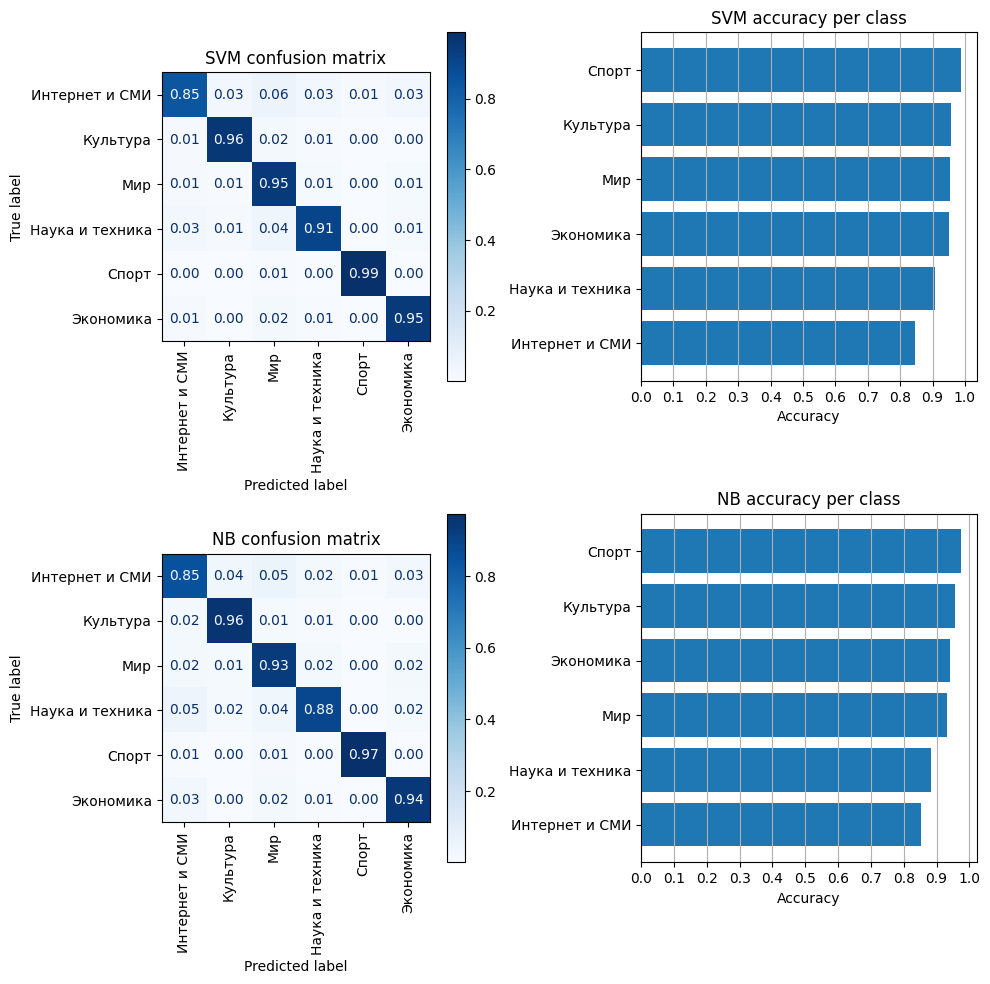

In [61]:
# Визуализация результатов моделей
y_preds = {'SVM': svm_pred, 'NB': nb_pred}
plot_results(y_preds)

## word2vec <a id='wv'></a>

In [79]:
from gensim.models import Word2Vec
import logging

# Настройка журнала для отображения информации об обучении Word2Vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [80]:
# Параметры для создания модели Word2Vec

min_count = 3   # Минимальное количество вхождений слова для учета в обучении модели
vec_size = 300  # Размерность векторного представления каждого слова
window = 5      # Максимальное расстояние между текущим и предсказанным словом в предложении

In [81]:
%%time

# Обучение модели Word2Vec
w2v = Word2Vec(sentences=[text.split() for text in df['text']],  # Список токенизированных предложений
               min_count=3,        # Минимальное количество вхождений слова для учета
               vector_size=300,    # Размерность векторного представления каждого слова
               window=3,           # Максимальное расстояние между текущим и предсказанным словом в предложении
               hs=1,               # Использование иерархического сэмплирования (hierarchical softmax)
               sg=0,               # Использование CBOW (Continuous Bag of Words) вместо Skip-gram
               negative=0,         # Количество "шумных" слов для отрицательной выборки
               workers=8,          # Количество ядер процессора, используемых для обучения параллельно
               epochs=8            # Количество проходов по корпусу данных (эпох обучения)
)

2024-03-03 21:24:55,519 : INFO : collecting all words and their counts
2024-03-03 21:24:55,522 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-03 21:24:55,692 : INFO : PROGRESS: at sentence #10000, processed 988211 words, keeping 53329 word types
2024-03-03 21:24:55,829 : INFO : PROGRESS: at sentence #20000, processed 1919081 words, keeping 82151 word types
2024-03-03 21:24:55,983 : INFO : PROGRESS: at sentence #30000, processed 2937921 words, keeping 105200 word types
2024-03-03 21:24:56,144 : INFO : PROGRESS: at sentence #40000, processed 4004979 words, keeping 123201 word types
2024-03-03 21:24:56,319 : INFO : PROGRESS: at sentence #50000, processed 5141896 words, keeping 140196 word types
2024-03-03 21:24:56,492 : INFO : PROGRESS: at sentence #60000, processed 6345693 words, keeping 155542 word types
2024-03-03 21:24:56,680 : INFO : PROGRESS: at sentence #70000, processed 7578094 words, keeping 168592 word types
2024-03-03 21:24:56,859 : INFO : PR

CPU times: user 32min 8s, sys: 1min 24s, total: 33min 33s
Wall time: 6min 58s


In [82]:
# Сохранение модели word2vec в файл w2v.pickle

import pickle
with open('w2v.pickle', 'wb') as f:
    pickle.dump(w2v, f, pickle.HIGHEST_PROTOCOL)

In [84]:
%%time
def get_vectorized_text(text, model):
    '''
    Функция для получения векторизованного текста
    '''
    vectorized_text = np.zeros(model.vector_size)  # Инициализируем вектор нулями
    count = 0  # Счетчик слов, для которых мы имеем векторы в модели
    for word in text.split():
        if word in model.wv:  # Проверяем, есть ли у нас вектор для данного слова
            vectorized_text += model.wv[word]  # Добавляем вектор слова к векторизованному тексту
            count += 1  # Увеличиваем счетчик
    if count != 0:
        vectorized_text /= count  # Усредняем вектор по количеству слов
    
    return vectorized_text

# Применяем функцию к столбцу 'text' в X_train, создавая новый столбец 'vectorized_text'
X_train['vectorized_text'] = X_train['text'].apply(lambda x: get_vectorized_text(x, w2v))

# Применяем функцию к столбцу 'text' в X_test, создавая новый столбец 'vectorized_text'
X_test['vectorized_text'] = X_test['text'].apply(lambda x: get_vectorized_text(x, w2v))


CPU times: user 1min 6s, sys: 6.46 s, total: 1min 12s
Wall time: 1min 19s


In [85]:
# Преобразование столбца 'vectorized_text' в матрицу признаков для обучающего набора
X_train_w2v = np.vstack(X_train['vectorized_text'].to_numpy())

# Преобразование столбца 'vectorized_text' в матрицу признаков для тестового набора
X_test_w2v = np.vstack(X_test['vectorized_text'].to_numpy())


## SVM <a id='wv_svm'></a>

In [86]:
%%time
smv_pred = evaluate_model(svm_model, x_train=X_train_w2v, x_test=X_test_w2v)

F1 score: 0.9154920725451637
Accuracy: 0.9235142118863049
CPU times: user 9.3 s, sys: 254 ms, total: 9.55 s
Wall time: 8.84 s


## KNN <a id='knn_svm'></a>

In [87]:
from sklearn.neighbors import KNeighborsClassifier

In [88]:
knn_model = KNeighborsClassifier(n_neighbors=7, n_jobs=8)

In [89]:
%%time
knn_pred = evaluate_model(knn_model, x_train=X_train_w2v, x_test=X_test_w2v)

F1 score: 0.9234101985143056
Accuracy: 0.9309653283967758
CPU times: user 19min 14s, sys: 3.81 s, total: 19min 18s
Wall time: 2min 34s


## XGBoost <a id='wv_xgb'></a>

In [90]:
import xgboost as xgb

In [91]:
%%time
xgb_model = xgb.XGBClassifier(objective='multi:softmax',eval_metric='mlogloss', verbosity=2,
                              num_class=6, max_depth=7, subsample=0.5, learning_rate=0.1,
                              n_estimators=125)
xgb_pred = evaluate_model(xgb_model, x_train=X_train_w2v, x_test=X_test_w2v)


F1 score: 0.9164682687458914
Accuracy: 0.9244783832774114
CPU times: user 11min 40s, sys: 1min 1s, total: 12min 41s
Wall time: 1min 39s


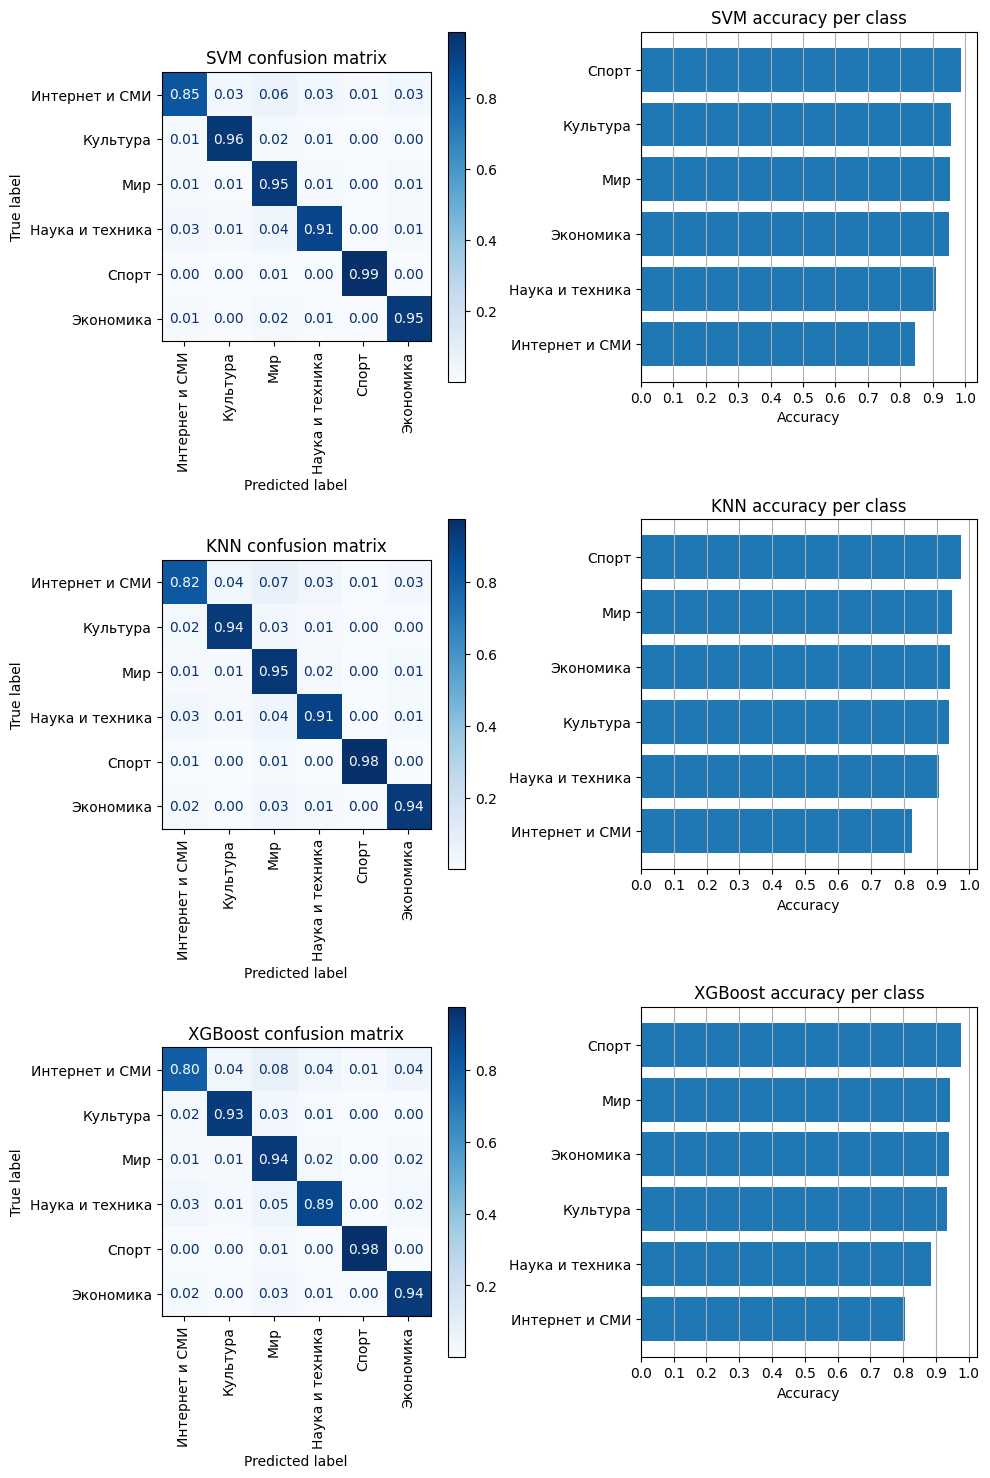

In [92]:
y_preds = {'SVM':svm_pred,
           'KNN':knn_pred,
           'XGBoost': xgb_pred}

plot_results(y_preds)

# word2vec & tf-idf <a id='wvidf'></a>

In [94]:
# Получение предобученных векторов слов из модели Word2Vec
word_vectors = w2v.wv

# Создание словаря TF-IDF, связывающего слова с их значениями
word2tfidf = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

# Инициализация матрицы для хранения векторизованных данных
vectorized_news = np.zeros((X.shape[0], vec_size), dtype="float32")

# Итерация по всем новостям с отображением прогресса
for i in tqdm(range(X.shape[0])):
    # Получение слов из текущей новости, которые присутствуют в предобученных векторах и имеют значения TF-IDF
    words = [word for word in X.text.iloc[i].split()
             if word in word_vectors and word in word2tfidf]
    
    # Получение векторов слов из предобученных векторов для каждого слова в текущей новости
    word_vecs = [word_vectors[word] for word in words]
    
    # Получение значений TF-IDF для каждого слова в текущей новости
    word_idfs = [word2tfidf[word] for word in words]
    
    # Создание вектора для текущей новости путем усреднения векторов слов с использованием значений TF-IDF в качестве весов
    vectorized_news[i, :] = np.average(word_vecs, axis=0, weights=word_idfs)


100%|█████████████████████████████████| 432147/432147 [02:08<00:00, 3368.25it/s]


In [95]:
# Создание целевой переменной из матрицы векторизованных данных
X_w2_idf = pd.DataFrame(vectorized_news)

In [96]:
X_w2_idf.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.094901,-0.008358,-0.079933,-0.009397,0.008702,-0.130630,0.044403,-0.048035,0.116042,0.073238,...,0.201574,0.017400,-0.213006,-0.056754,0.008809,-0.107746,0.076070,0.253663,0.085472,-0.083056
1,0.297227,-0.138173,-0.119840,-0.322424,0.386284,0.099575,-0.073771,-0.185773,-0.104683,0.456916,...,0.371234,0.260145,0.259097,-0.183316,-0.283756,0.260521,0.214456,0.053792,0.132695,-0.133998
2,0.035591,0.264232,0.111065,-0.009790,-0.086464,-0.076485,-0.030483,-0.085980,0.086266,0.082725,...,-0.149646,0.110165,-0.127488,0.041353,0.115052,-0.015107,0.160635,-0.134823,-0.233569,-0.008725
3,0.075425,-0.202155,0.102905,-0.114371,0.030943,-0.040472,-0.008953,-0.076379,-0.155875,0.205162,...,-0.131807,0.210031,-0.135641,-0.061430,-0.084276,-0.044755,0.081693,-0.046367,-0.117924,0.047823
4,-0.094543,-0.073241,0.055743,-0.019164,-0.012049,0.056728,0.060120,-0.043621,0.126838,0.075276,...,-0.049697,0.043295,-0.191075,0.157545,-0.007956,0.216327,-0.006718,-0.102292,-0.229836,-0.081615


In [97]:
X_w2_idf.shape

(432147, 300)

In [98]:
# Разделение данных на обучающий и тестовый наборы
X_train_w2v_idf, X_test_w2v_idf, y_train, y_test = train_test_split(X_w2_idf, y, test_size=0.3,
                                                    stratify=y, random_state=42)

## SVM <a id='wvidf_svm'></a>

In [99]:
%%time
smv_pred = evaluate_model(svm_model, x_train=X_train_w2v_idf, x_test=X_test_w2v_idf)

F1 score: 0.9115475554297623
Accuracy: 0.920644837826372
CPU times: user 9.5 s, sys: 277 ms, total: 9.78 s
Wall time: 9.11 s


## KNN <a id='wvidf_knn'></a>

In [82]:
knn_model = KNeighborsClassifier(n_neighbors=7, n_jobs=8)

In [83]:
%%time
knn_pred = evaluate_model(knn_model, x_train=X_train_w2v, x_test=X_test_w2v)

F1 score: 0.9236404618932278
Accuracy: 0.9310440577563865
CPU times: user 20min 14s, sys: 5.47 s, total: 20min 20s
Wall time: 2min 52s


## XGBoost <a id='wvidf_xgb'></a>

In [84]:
import xgboost as xgb

In [85]:
%%time
xgb_model = xgb.XGBClassifier(objective='multi:softmax',eval_metric='mlogloss', verbosity=2,
                              num_class=6, max_depth=7, subsample=0.5, learning_rate=0.1,
                              n_estimators=125)
xgb_pred = evaluate_model(xgb_model, x_train=X_train_w2v, x_test=X_test_w2v)


F1 score: 0.9155349485012221
Accuracy: 0.9235005553498704
CPU times: user 11min 44s, sys: 1min 1s, total: 12min 45s
Wall time: 1min 43s


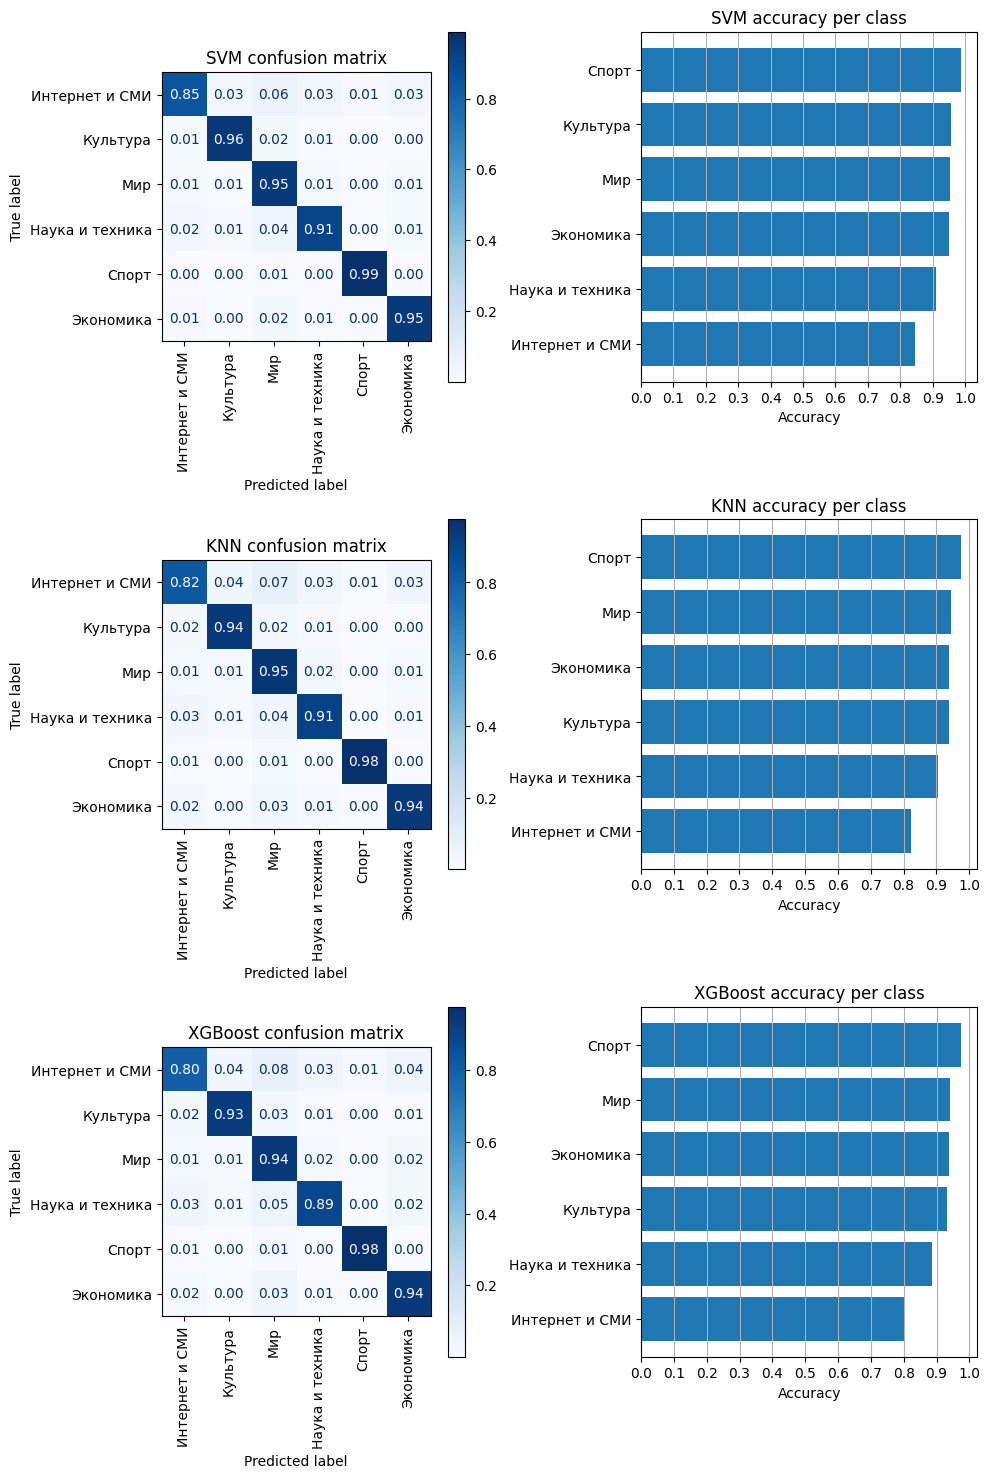

In [86]:
y_preds = {'SVM':svm_pred,
           'KNN':knn_pred,
           'XGBoost': xgb_pred}

plot_results(y_preds)

# NewsClassifier <a id='news_clf'></a>

In [4]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import defaultdict
from pymystem3 import Mystem  # Подгружаем Mystem из библиотеки pymystem3
from functools import lru_cache
from tqdm import tqdm  # Импортируем tqdm для отслеживания прогресса
from nltk.corpus import stopwords
from stop_words import get_stop_words
from functools import lru_cache # Декоратор lru_cache используется для кэширования результатов вызова функции
tqdm.pandas() # Инициализация tqdm для отслеживания прогресса выполнения операций

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
import logging

class Pipeline(object):
    '''Класс Pipeline представляет собой последовательность трансформаций данных.'''
    def __init__(self, *args):
        # Инициализируется списком функций-трансформаторов, которые будут применены последовательно.
        self.transformations = args
        
    def __call__(self, x):
        # Метод __call__ позволяет экземпляру класса быть вызванным как функция.
        # Принимает входные данные x и применяет к ним все трансформации из списка.
        res = x
        for f in self.transformations:
            res = f(res)
        # Возвращает результат после применения всех трансформаций.
        return res


class NewsClassifier:
    '''Класс NewsClassifier представляет собой классификатор новостей.'''
    def __init__(self):
        # Инициализация Mystem для лемматизации текста
        self.mystem = Mystem()
        # Инициализация стоп слов
        self.STOP_WORDS = None
        # Инициализация энкодера для целевых классов
        self.le = LabelEncoder()
        # Инициализация энкодера tf-idf
        self.tfidf_vectorizer = None
        # Инициализация век
        self.word_vectors = None
        self.word2tfidf = None
        self.vec_size = 300
        self.knn_model = KNeighborsClassifier(n_neighbors=7, n_jobs=8)

    def preprocess_text(self, X):
        # Загружаем стоп-слова для библиотеки nltk
        nltk.download('stopwords')

        # Получение стоп-слов для английского и русского языков
        en_stop_words = set(get_stop_words('en')) | set(stopwords.words('english'))
        ru_stop_words = set(get_stop_words('ru')) | set(stopwords.words('russian'))
        
        # Общий набор стоп-слов
        COMMON_STOP_WORDS = {'также', 'новость', 'новости', 'однако',
                            'это', 'кроме', 'который', 'которая', 'которые',
                            'которое', 'котором', 'которых', 'кроме',
                            'году', 'год', 'годом', 'года', 'лента',
                            'риа', 'тасс', 'редакция', 'газета', 'интерфакс',
                            'village', 'reuters', 'уточняться', 'частности', 
                            'сообщать', 'сообщается', 'сообщает', 'заявил',
                            'заявить', 'оффициальный', 'заявлять',  'оффициально',
                            'таким', 'образ', 'образом', 'данный', 'ранее', 'уточняться'}
        
        # Общий набор стоп-слов для всех языков
        self.STOP_WORDS = en_stop_words | ru_stop_words | COMMON_STOP_WORDS
    
        # Пайплайн для обработки текта
        TEXT_PIPELINE = Pipeline(self.remove_xml, self.get_lower, self.remove_punctuation, self.lemmatize_words)
        # Применение пайплайна обработки текста к столбцу 'text'
        text = X['text'].progress_apply(TEXT_PIPELINE)
        # Применение пайплайна обработки текста к столбцу 'title'
        title = X['title'].progress_apply(TEXT_PIPELINE)

        # Создание целевой пременной, объедняя столбцы 'title' и 'text'
        return pd.DataFrame(title + ' ' + text, columns=['text'])

    def remove_xml(self, text):
        """Удаление из текста в xml формата."""
        return text[59:-22] if isinstance(text, str) and '<?xml version="1.0"' in text else text
    
    def get_lower(self, text):
        """Преобразование текста в нижний регистр."""
        return str(text).lower()

    def remove_punctuation(self, text):
        """Удаление неалфавитных символов с сохранением дефисов и апострофов."""
        return ''.join([c if c.isalpha() or c in ['-', "'"] else ' ' for c in text])
    
    @lru_cache(maxsize=None)
    def get_word_normal_form(self, word):
        """Получение нормальной формы слова с использованием Mystem."""
        return ''.join(self.mystem.lemmatize(word)).strip().replace('ё', 'е').strip('-')
        
    def lemmatize_words(self, text):
        """Лемматизация слов в заданном тексте и фильтрация стоп-слов."""
        return ' '.join([self.get_word_normal_form(word) for word in text.split() if len(
            self.get_word_normal_form(word)) > 2 and self.get_word_normal_form(word) not in self.STOP_WORDS])

    def train_tfidf_vectorizer(self, X):
        """Обучение tf-idf с min_df=3 и ngram_range=(1, 2)."""
        self.tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1, 2), lowercase=False).fit(X)

    def train_word2vec_model(self, df):
        '''Обучение word2vec с window=3 и epochs=8.'''
        # Настройка журнала для отображения информации об обучении Word2Vec
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
        
        sentences = [text.split() for text in df['text']]
        self.word_vectors = Word2Vec(sentences=sentences, min_count=3, vector_size=self.vec_size, window=3,
                                     hs=1, sg=0, negative=0, workers=8, epochs=8).wv
    
    def calculate_word2tfidf(self, X):
        '''Вычисление word2tfidf'''
        self.word2tfidf = dict(zip(self.tfidf_vectorizer.get_feature_names_out(), self.tfidf_vectorizer.idf_))

    def vectorize_text(self, X):
        '''Усредние вектора слов в каждой из новостей с весами tf-idf'''
        # Создаем массив нулей для хранения векторизованных новостей
        vectorized_news = np.zeros((X.shape[0], self.vec_size), dtype="float32")
        
        # Итерируемся по каждой новости в наборе данных
        for i in tqdm(range(X.shape[0])):
            # Разбиваем текст новости на слова и фильтруем их, оставляя только те, которые есть в word_vectors и word2tfidf
            words = [word for word in X.text.iloc[i].split()
                    if word in self.word_vectors and word in self.word2tfidf]
            
            # Получаем вектора слов и их значения tf-idf
            word_vecs = [self.word_vectors[word] for word in words]
            word_idfs = [self.word2tfidf[word]  for word in words]
            
            # Усредняем вектора слов, применяя веса tf-idf, и сохраняем результат в массив vectorized_news
            vectorized_news[i,:] = np.average(word_vecs, axis=0, weights=word_idfs)

        return vectorized_news
        
    def fit(self, X_train, y_train):
        # Препроцессинг текста входных данных
        print('Обработка текста входных данных')
        X_train_preprocessed = self.preprocess_text(X_train)
        
        # Кодирование меток классов
        print('Кодирование меток классов')
        y_train_encoded = self.le.fit_transform(y_train)
        
        # Векторизация текста с использованием TF-IDF
        print('Векторизация текста с использованием TF-IDF')
        self.train_tfidf_vectorizer(X_train_preprocessed['text'])
        
        # Обучение модели Word2Vec
        print('Обучение модели Word2Vec')
        self.train_word2vec_model(X_train_preprocessed)
        
        # Расчет значений word2tfidf для каждого слова в тексте
        print('Расчет значений word2tfidf для каждого слова в тексте')
        self.calculate_word2tfidf(X_train_preprocessed['text'])
        
        # Векторизация текста с использованием Word2Vec и TF-IDF
        print('Векторизация текста с использованием Word2Vec и TF-IDF')
        X_train_w2v_idf = pd.DataFrame(self.vectorize_text(X_train_preprocessed))
        
        # Обучение модели KNN
        print('Обучение модели KNN')
        self.knn_model.fit(X_train_w2v_idf, y_train_encoded)


    def predict(self, X_test):
        # Предобработка текста входных данных
        print('Обработка текста входных данных')
        X_test_preprocessed = self.preprocess_text(X_test)

        # Векторизация текста с использованием Word2Vec и TF-IDF
        print('Векторизация текста с использованием Word2Vec и TF-IDF')
        X_test_w2v_idf = pd.DataFrame(self.vectorize_text(X_test_preprocessed))

        # Выполнение прогнозов с использованием обученной модели KNN
        print('Выполнение прогнозов с использованием обученной модели KNN')
        predictions = self.knn_model.predict(X_test_w2v_idf.values)

        # Обратное преобразование закодированных предсказаний в исходные метки классов
        return self.le.inverse_transform(predictions)

    

In [6]:
%%time
df = pd.read_csv('test.csv')
X = df[['title', 'text']]
y = df['topic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
news_clf = NewsClassifier()
news_clf.fit(X_train, y_train)
y_pred = news_clf.predict(X_test)

[nltk_data] Downloading package stopwords to /Users/bulat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Обработка текста входных данных


100%|███████████████████████████████| 289545/289545 [00:02<00:00, 112103.56it/s]


Кодирование меток классов
Векторизация текста с использованием TF-IDF
Обучение модели Word2Vec


2024-03-04 05:15:03,071 : INFO : collecting all words and their counts
2024-03-04 05:15:03,074 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-04 05:15:03,261 : INFO : PROGRESS: at sentence #10000, processed 1209558 words, keeping 64007 word types
2024-03-04 05:15:03,444 : INFO : PROGRESS: at sentence #20000, processed 2417568 words, keeping 93388 word types
2024-03-04 05:15:03,610 : INFO : PROGRESS: at sentence #30000, processed 3618739 words, keeping 116175 word types
2024-03-04 05:15:03,791 : INFO : PROGRESS: at sentence #40000, processed 4819765 words, keeping 135677 word types
2024-03-04 05:15:03,971 : INFO : PROGRESS: at sentence #50000, processed 6028106 words, keeping 152832 word types
2024-03-04 05:15:04,154 : INFO : PROGRESS: at sentence #60000, processed 7233058 words, keeping 168282 word types
2024-03-04 05:15:04,334 : INFO : PROGRESS: at sentence #70000, processed 8444373 words, keeping 182834 word types
2024-03-04 05:15:04,508 : INFO : P

Расчет значений word2tfidf для каждого слова в тексте
Векторизация текста с использованием Word2Vec и TF-IDF


100%|█████████████████████████████████| 289545/289545 [00:58<00:00, 4943.78it/s]


Обучение модели KNNl


[nltk_data] Downloading package stopwords to /Users/bulat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Обработка текста входных данных


100%|████████████████████████████████| 142613/142613 [00:01<00:00, 96920.16it/s]


Векторизация текста с использованием Word2Vec и TF-IDF


100%|█████████████████████████████████| 142613/142613 [00:30<00:00, 4746.25it/s]


Выполнение прогнозов с использованием обученной модели KNN
CPU times: user 50min 20s, sys: 1min 20s, total: 51min 40s
Wall time: 12min 50s


## Конечные результаты классификатора

In [7]:
print('F1 score:', f1_score(y_test, y_pred, average='macro'))
print('Accuracy:', accuracy_score(y_test, y_pred))

F1 score: 0.9198418116273315
Accuracy: 0.9278326660262388
